# Visualization

This Jupyter notebook presents visualization results for the **Li<sub>2</sub>S** system obtained using a **PyTorch-based Distributed Data Parallel (DDP)** implementation trained on **NERSC** high-performance computing resources.

Results may be compared against the original GDyNet visualization notebook:
https://github.com/txie-93/gdynet/blob/master/notebooks/visualization.ipynb


### Training and Evaluation

Training was performed on NERSC using distributed data parallel (DDP) with PyTorch.

**Hyperparameters:**
- Batch Size: 10240
- Learning Rate: 0.0005
- Number of Classes: 2
- Atom Feature Length: 16
- Number of Convolutions: 2
- Epochs: 30

In [ ]:
import os
import sys

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)
os.chdir(project_root)

print(f"Project root: {project_root}")

In [ ]:
import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Project-specific imports (updated paths)
from postprocess.koopman_postprocess import (
    KoopmanAnalysis,
    plot_timescales,
    plot_ck_tests,
    plot_eigenanalysis,
)

# Plotting configuration
plt.rcParams.update({
    'figure.figsize': (8, 5),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

In [3]:
params = {
    'train_flist': ['../data/li2s-traj-graph-train.npz'],
    'val_flist': ['../data/li2s-traj-graph-val.npz'],
    'test_flist': ['../data/li2s-traj-graph-test.npz'],
    'job_dir': 'output/gdynet_vanilla_test3_amp',
    'mode': 'direct',
    'tau': 1,
    'n_classes': 2,
    'k_eig': 0,
    'atom_fea_len': 16,
    'n_conv': 2,
    'learning_rate': 0.0005,
    'batch_size': 10240,
    'use_bn': True,
    'n_epoch': 30,
    'shuffle': True,
    'random_seed': 123,
}

# Time parameters for Li2S
TIME_UNIT_NS = 1e-4  # 0.1 ps timestep

### Training Metrics

Load and plot the training metrics from the .npy files.

In [4]:
# Load metrics from npy files
metrics_dir = os.path.join(params['job_dir'], "metrics")

metrics = {}
for fp in sorted(glob.glob(os.path.join(metrics_dir, "*.npy"))):
    key = os.path.splitext(os.path.basename(fp))[0]
    arr = np.load(fp)
    metrics[key] = np.asarray(arr).squeeze()

if not metrics:
    raise FileNotFoundError(f"No .npy files found in: {metrics_dir}")

# Make all series same length
lengths = {k: len(v) for k, v in metrics.items() if np.ndim(v) == 1}
min_len = min(lengths.values())
metrics_1d = {k: v[:min_len] for k, v in metrics.items()}

# Build DataFrame
df = pd.DataFrame(metrics_1d)
df["epoch"] = np.arange(min_len)

print("Loaded metrics:", list(df.columns))

Loaded metrics: ['train_losses_avg', 'train_losses_last', 'train_vamp1_scores_avg', 'train_vamp1_scores_last', 'train_vamp2_scores_avg', 'train_vamp2_scores_last', 'val_losses_avg', 'val_losses_last', 'val_vamp1_scores_avg', 'val_vamp1_scores_last', 'val_vamp2_scores_avg', 'val_vamp2_scores_last', 'epoch']


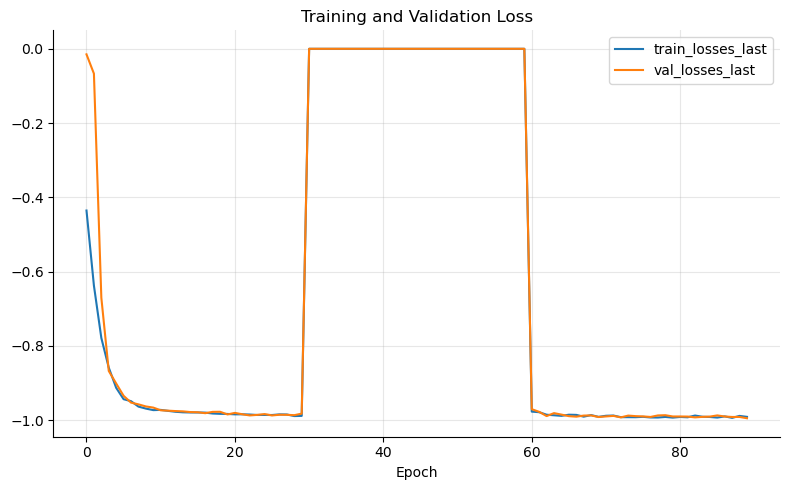

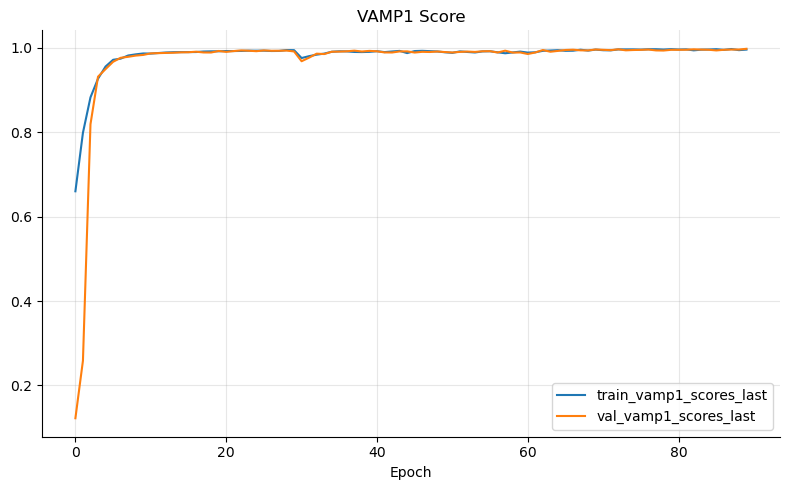

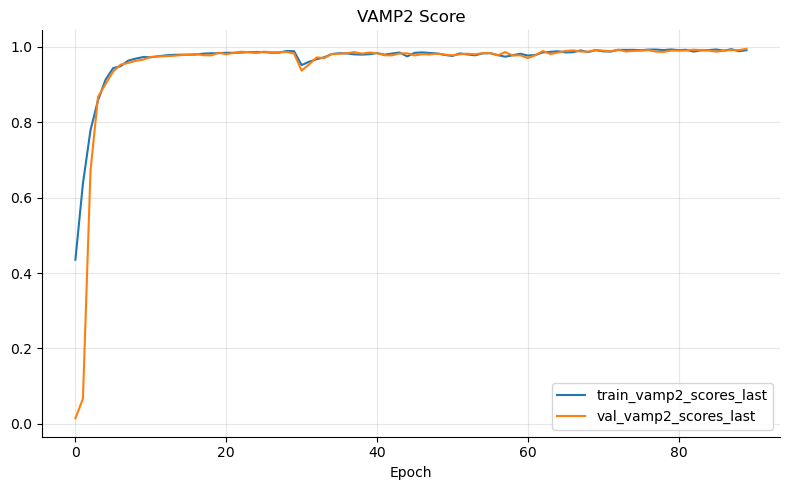

In [5]:
# Helper function to plot metric pairs
def plot_pair(train_col, val_col, title):
    cols = [c for c in [train_col, val_col] if c in df.columns]
    if len(cols) == 0:
        print(f"[skip] {title}: columns not found: {train_col}, {val_col}")
        return
    ax = df.plot.line(x="epoch", y=cols, title=title)
    ax.set_xlabel("Epoch")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot training metrics
plot_pair("train_losses_last", "val_losses_last", "Training and Validation Loss")
plot_pair("train_vamp1_scores_last", "val_vamp1_scores_last", "VAMP1 Score")
plot_pair("train_vamp2_scores_last", "val_vamp2_scores_last", "VAMP2 Score")

### Load Predicted State Probabilities

Load the predicted state probabilities from the test dataset.

In [6]:
pred_dir = os.path.join(params['job_dir'], "predictions")

# Pick a file: prefer the named one, otherwise first .npy in folder
preferred = os.path.join(pred_dir, "gdynet_vanilla_predictions.npy")
if os.path.exists(preferred):
    pred_path = preferred
else:
    files = sorted(glob.glob(os.path.join(pred_dir, "*.npy")))
    if not files:
        raise FileNotFoundError(f"No .npy files found in {pred_dir}")
    pred_path = files[0]

print("Loading:", pred_path)
preds = np.load(pred_path)
print("Predictions shape:", preds.shape)

# Verify shape
if preds.ndim != 3:
    raise ValueError(f"Expected preds with 3 dims (F,B,K). Got {preds.shape}")

F, B, K = preds.shape
print(f"Frames: {F}, Batch: {B}, Classes: {K}")

Loading: output/gdynet_vanilla_test3_amp/predictions/gdynet_vanilla_predictions.npy
Predictions shape: (1000000, 1, 2)
Frames: 1000000, Batch: 1, Classes: 2


### State Populations

Generate a pie-chart depicting the populations of individual states.

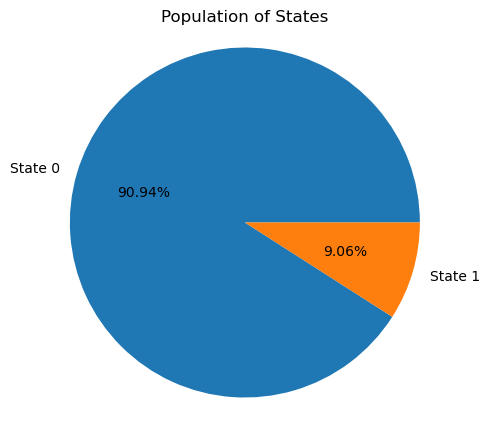

In [7]:
# Population of each state over all frames+batch
probs = preds.sum(axis=(0, 1))
probs = probs / probs.sum()

labels = [f"State {i}" for i in range(K)]

plt.figure(figsize=(5, 5))
plt.pie(probs, labels=labels, autopct="%1.2f%%")
plt.axis("image")
plt.title("Population of States")
plt.show()

### Relaxation Timescales

Create a plot illustrating the evolution of relaxation timescales as a function of lag time. The relaxation timescales correspond to the characteristic times implied by the transition matrix at a given lag time. The model begins to adhere to the Markovian assumption when the relaxation timescales cease to vary. The lag time array, denoted as `lag`, is used to calculate the relaxation timescales. The `time_unit_in_ns` variable is used to convert the timesteps into units of nanoseconds.

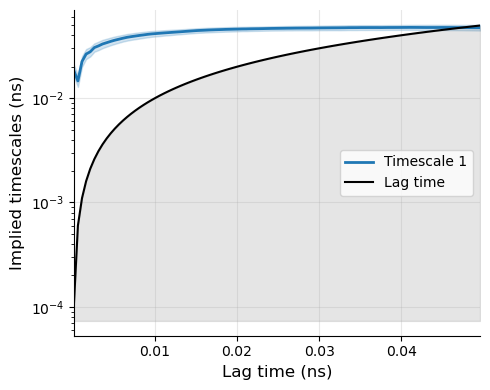

In [8]:
max_tau = 500
lag = np.arange(1, max_tau, 5)
plot_timescales(
    preds, 
    lag, 
    n_splits=5, 
    split_axis=0, 
    time_unit_in_ns=TIME_UNIT_NS
);

### Chapman-Kolmogorov Test

Perform CK test to verify the Markovian assumption. The transition matrix at the chosen lag time `tau_msm` should pass the CK test. The values predicted by direct multiplication of the transition matrix (blue) and estimated from the trajectory data (red) should match well. Note that we should choose the smallest `tau_msm` because it provides the most detailed dynamical information.

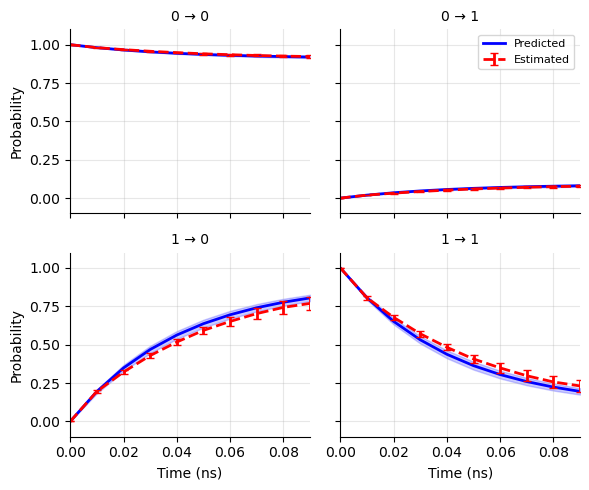

In [9]:
tau_msm = 100
plot_ck_tests(
    preds, 
    tau_msm=tau_msm, 
    steps=10, 
    n_splits=5, 
    split_axis=0, 
    time_unit_in_ns=TIME_UNIT_NS
);

### Eigenvalue Decomposition

Perform eigenvalue decomposition of the Koopman matrix (`koopman_op`). The eigenvectors corresponding to each relaxation mode are plotted. The largest eigenvalue should be 1 with relaxation timescale of infinity.

For Li<sub>2</sub>S with 2 states:
- **The second eigenvector shows the transition between the two dynamical states.**

Koopman operator:
[[0.98058832 0.01941168]
 [0.1938292  0.8061708 ]]
Eig 0
Value: 1.0000000000008045
Timescale: inf (stationary)
Stationary distribution: [0.90896832 0.09103168]
Vector: [0.99502256 0.09964987]

Eig 1
Value: 0.7867591205597921
Timescale: 0.04169565376297437 ns
Vector: [-0.70710678  0.70710678]



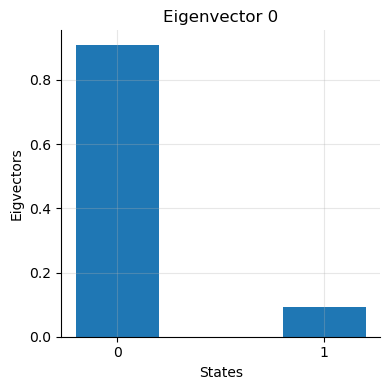

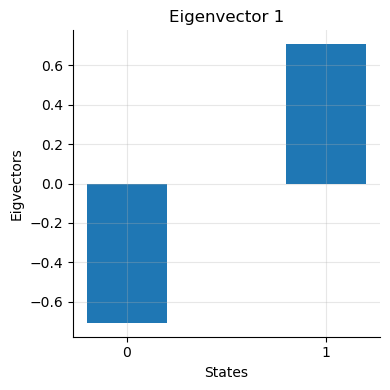

In [10]:
# Create analyzer
vamp_analyzer = KoopmanAnalysis(epsilon=1e-5)

# Estimate Koopman operator
koopman_op = vamp_analyzer.estimate_koopman_op(preds, tau_msm)

print("Koopman operator:")
print(koopman_op)

# Plot eigenanalysis
eigvals, eigvecs = plot_eigenanalysis(
    koopman_op,
    tau_msm,
    time_unit_in_ns=TIME_UNIT_NS
);

### Stationary Distribution

Calculate the stationary distribution from the Koopman operator eigenvector with eigenvalue = 1.

In [11]:
# Eigendecomposition of K^T
eigvals_full, eigvecs_full = np.linalg.eig(koopman_op.T)

print("Eigenvalues:", eigvals_full)
print("\nEigenvectors:")
print(eigvecs_full)

# Stationary distribution (eigenvector with eigenvalue = 1)
idx = np.argmax(np.abs(eigvals_full))
stationary = np.real(eigvecs_full[:, idx])
stationary = stationary / stationary.sum()  # Normalize
print("\nStationary distribution:", stationary)

Eigenvalues: [1.         0.78675912]

Eigenvectors:
[[ 0.99502256 -0.70710678]
 [ 0.09964987  0.70710678]]

Stationary distribution: [0.90896832 0.09103168]


### 3D Visualization

Visualize the probability distribution of the states in 3D space. First, load the trajectory coordinates from the test dataset.

In [13]:
traj_coords = np.load("/Users/abhijeet/cnms/ferronet/gdynet_dataset/lis/graphs/traj_coords_test.npy")
target_index = np.load("/Users/abhijeet/cnms/ferronet/gdynet_dataset/lis/graphs/target_index_test.npy")

Plot the probability of being in each state in the 3D space. The second eigenvector shows the transition between octahedral and tetrahedral sites.

/var/folders/kg/jr69wj992xn_tztwvcvq8s1r0000gn/T/ipykernel_60104/2106535898.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


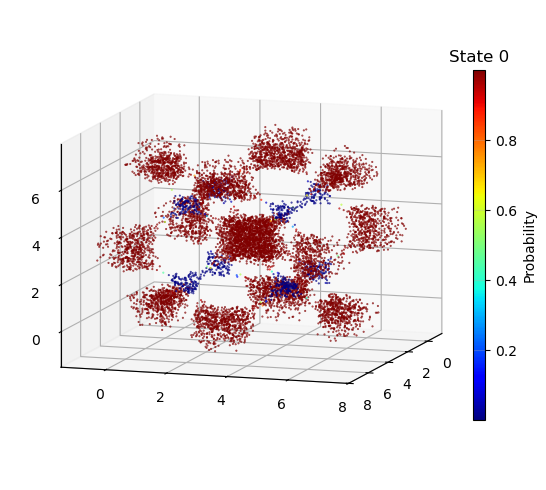

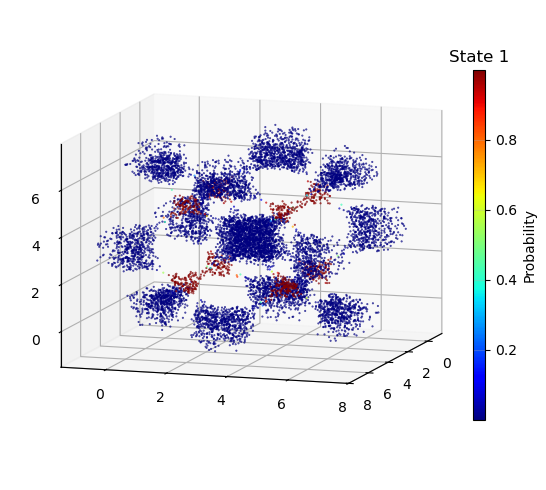

In [14]:
import matplotlib
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D

def scatter3d(x, y, z, cs, title, colorsMap='jet', angle=30):
    """Plot 3D scatter with color-coded probabilities."""
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d', proj_type='ortho')
    ax.axis('auto')
    ax.scatter(x, y, z, s=1, c=scalarMap.to_rgba(cs), marker='.', alpha=0.8)
    scalarMap.set_array(cs)
    ax.view_init(10, angle)
    
    # Add colorbar
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(scalarMap, cax=cbar_ax)
    cbar.set_label('Probability')
    
    plt.title(title, ha='center')
    plt.tight_layout()
    plt.show()

# Plot probability distribution for each state
# Using atom index 0 (first Li atom) and subsampling every 100 frames
for i in range(params['n_classes']):
    scatter3d(
        traj_coords[::100, 0, 0], 
        traj_coords[::100, 0, 1], 
        traj_coords[::100, 0, 2],
        cs=preds.reshape(-1, params['n_classes'])[::100, i], 
        title=f'State {i}',
        angle=18
    )